# **📌 Packages**

In [1]:
# 기본
import pandas as pd
import numpy as np

In [2]:
# 시각화
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

## 한글 처리
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 17,8

import warnings
warnings.filterwarnings(action='ignore')

# **📌 대구 교통 사고 피해 예측 AI 경진대회 Baseline Code**
- `train_org` / `test_org` : original df
- `train_df` / `test_df` : 날짜, 시간정보, 공간정보, 도로형태 정보 전처리한 df (두 df 모두 ECLO 미포함)

## **🔻 Fixed Random Seed**  

seed 값에 의해 동일한 코드를 사용해도 결과가 다를 수 있기에, 동일한 결과를 위해 seed 값을 고정시킵니다

In [3]:
import os
import random
import numpy as np

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42)

## **🔻 데이터 불러오기 및 상위행 확인**  

train.csv, test.csv 파일을 로드하여 상위행을 출력해 봅시다

In [4]:
import pandas as pd
from datetime import datetime

train = pd.read_csv('open/train.csv', encoding = "utf-8", low_memory=False)
test = pd.read_csv('open/test.csv', encoding = "utf-8", low_memory=False)

display(train.head())
display(test.tail())

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
10958,ACCIDENT_50567,2022-12-31 18,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차
10959,ACCIDENT_50568,2022-12-31 18,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차
10960,ACCIDENT_50569,2022-12-31 20,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차
10961,ACCIDENT_50570,2022-12-31 20,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차
10962,ACCIDENT_50571,2022-12-31 21,토요일,맑음,대구광역시 동구 효목동,교차로 - 교차로부근,건조,차대차


## **🔻 데이터 전처리**  

현재 '사고일시', '시군구', '도로형태' 컬럼은 반복되는 패턴으로 여러 정보를 포함하고 있습니다
이런 반복되는 패턴을 일반화하면 pandas에서 제공하는 str.extract를 통해 한 번에 추출 가능합니다

### **1. 파생 변수 생성 : 날짜, 시간정보 생성**

'사고일시' 컬럼으로 부터 연도, 월, 일, 시간 정보 추출 및 변환 합니다

In [5]:
import pandas as pd
from datetime import datetime

train_org = pd.read_csv('open/train.csv',encoding = "utf-8", low_memory=False)
test_org = pd.read_csv('open/test.csv', encoding = "utf-8", low_memory=False)

display(train_org.head())
display(test_org.tail())

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3


,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
10958,ACCIDENT_50567,2022-12-31 18,토요일,맑음,대구광역시 남구 대명동,단일로 - 터널,건조,차대차
10959,ACCIDENT_50568,2022-12-31 18,토요일,맑음,대구광역시 수성구 시지동,단일로 - 기타,건조,차대차
10960,ACCIDENT_50569,2022-12-31 20,토요일,맑음,대구광역시 수성구 연호동,단일로 - 기타,건조,차대차
10961,ACCIDENT_50570,2022-12-31 20,토요일,맑음,대구광역시 수성구 범물동,교차로 - 교차로부근,건조,차대차
10962,ACCIDENT_50571,2022-12-31 21,토요일,맑음,대구광역시 동구 효목동,교차로 - 교차로부근,건조,차대차


In [6]:
train_df = train_org.copy()
test_df = test_org.copy()

time_pattern = r'(\d{4})-(\d{1,2})-(\d{1,2}) (\d{1,2})'

train_df[['연', '월', '일', '시간']] = train_org['사고일시'].str.extract(time_pattern)
train_df[['연', '월', '일', '시간']] = train_df[['연', '월', '일', '시간']].apply(pd.to_numeric) # 추출된 문자열을 수치화해줍니다
train_df = train_df.drop(columns=['사고일시']) # 정보 추출이 완료된 '사고일시' 컬럼은 제거합니다

# 해당 과정을 test_x에 대해서도 반복해줍니다
test_df[['연', '월', '일', '시간']] = test_org['사고일시'].str.extract(time_pattern)
test_df[['연', '월', '일', '시간']] = test_df[['연', '월', '일', '시간']].apply(pd.to_numeric)
test_df = test_df.drop(columns=['사고일시'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류',\n       '법규위반', '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '시군구', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간'], dtype='object')"

### **2. 파생 변수 생성 : 공간(위치) 정보 생성**

'시군구' 컬럼으로부터 의미 있는 공산 정보를 추출 및 변환 합니다

In [7]:
location_pattern = r'(\S+) (\S+) (\S+)'

train_df[['도시', '구', '동']] = train_org['시군구'].str.extract(location_pattern)
train_df = train_df.drop(columns=['시군구'])

test_df[['도시', '구', '동']] = test_org['시군구'].str.extract(location_pattern)
test_df = test_df.drop(columns=['시군구'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반',\n       '가해운전자 차종', '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종',\n       '피해운전자 성별', '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수',\n       'ECLO', '연', '월', '일', '시간', '도시', '구', '동'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '도로형태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시',\n       '구', '동'],\n      dtype='object')"

### **3. 파생 변수 추출 : 도로 형태 정보 추출**  

'도로형태' 컬럼은 '단일로 - 기타'와 같은 패턴으로 구성되어 있습니다. 이를 두종류의 독립된 정보로 보고 두개의 컬럼으로 분리하여 생성합니다.

In [8]:
road_pattern = r'(.+) - (.+)'

train_df[['도로형태1', '도로형태2']] = train_org['도로형태'].str.extract(road_pattern)
train_df = train_df.drop(columns=['도로형태'])

test_df[['도로형태1', '도로형태2']] = test_org['도로형태'].str.extract(road_pattern)
test_df = test_df.drop(columns=['도로형태'])

display(f"columns of train_df : {train_df.columns}")
display(f"columns of test_df : {test_df.columns}")

"columns of train_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '사고유형 - 세부분류', '법규위반', '가해운전자 차종',\n       '가해운전자 성별', '가해운전자 연령', '가해운전자 상해정도', '피해운전자 차종', '피해운전자 성별',\n       '피해운전자 연령', '피해운전자 상해정도', '사망자수', '중상자수', '경상자수', '부상자수', 'ECLO', '연',\n       '월', '일', '시간', '도시', '구', '동', '도로형태1', '도로형태2'],\n      dtype='object')"

"columns of test_df : Index(['ID', '요일', '기상상태', '노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구', '동',\n       '도로형태1', '도로형태2'],\n      dtype='object')"

# **📌 추가 전처리**
- `train_df` / `test_df` : test 에 있는 컬럼들만 사용해 train 재구성 (두 df 모두 ECLO 미포함)

## **🔻 train, test 컬럼 수 맞추기**

test에 있는 컬럼들만 사용하여 train 데이터를 구성했습니다.

In [9]:
train_df= train_df[['ID','요일','기상상태','노면상태', '사고유형', '연', '월', '일', '시간', '도시', '구','동', '도로형태1', '도로형태2']]
train_df

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,2019,1,1,0,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,2019,1,1,2,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,2019,1,1,4,대구광역시,동구,신암동,단일로,기타
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,금요일,맑음,건조,차대차,2021,12,31,19,대구광역시,수성구,수성동3가,교차로,교차로안
39605,ACCIDENT_39605,금요일,맑음,건조,차대차,2021,12,31,19,대구광역시,달서구,상인동,단일로,기타
39606,ACCIDENT_39606,금요일,맑음,건조,차대차,2021,12,31,21,대구광역시,달서구,월성동,교차로,교차로안
39607,ACCIDENT_39607,금요일,맑음,건조,차대차,2021,12,31,22,대구광역시,달서구,장동,기타,기타


In [10]:
display(train_df.head())
display(test_df.head())

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,2019,1,1,0,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,2019,1,1,2,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,2019,1,1,4,대구광역시,동구,신암동,단일로,기타


,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_39609,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,상동,교차로,교차로안
1,ACCIDENT_39610,토요일,맑음,건조,차대사람,2022,1,1,1,대구광역시,수성구,지산동,단일로,기타
2,ACCIDENT_39611,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,수성동2가,교차로,교차로안
3,ACCIDENT_39612,토요일,맑음,건조,차대차,2022,1,1,4,대구광역시,수성구,신매동,단일로,기타
4,ACCIDENT_39613,토요일,맑음,건조,차대차,2022,1,1,6,대구광역시,달서구,감삼동,교차로,교차로안


In [11]:
display(train_df.info())
display(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      39609 non-null  object
 1   요일      39609 non-null  object
 2   기상상태    39609 non-null  object
 3   노면상태    39609 non-null  object
 4   사고유형    39609 non-null  object
 5   연       39609 non-null  int64 
 6   월       39609 non-null  int64 
 7   일       39609 non-null  int64 
 8   시간      39609 non-null  int64 
 9   도시      39609 non-null  object
 10  구       39609 non-null  object
 11  동       39609 non-null  object
 12  도로형태1   39609 non-null  object
 13  도로형태2   39609 non-null  object
dtypes: int64(4), object(10)
memory usage: 4.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10963 entries, 0 to 10962
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      10963 non-null  object
 1   요일      10963 non-null  object
 2   기상상태    10963 non-null  object
 3   노면상태    10963 non-null  object
 4   사고유형    10963 non-null  object
 5   연       10963 non-null  int64 
 6   월       10963 non-null  int64 
 7   일       10963 non-null  int64 
 8   시간      10963 non-null  int64 
 9   도시      10963 non-null  object
 10  구       10963 non-null  object
 11  동       10963 non-null  object
 12  도로형태1   10963 non-null  object
 13  도로형태2   10963 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.2+ MB


None

# **📌 인코딩 (One-Hot)**
- `df_merge_enc` : 인코딩 진행 위해 `train_df`, `test_df` merged df
- `df_drop_city_days` : '도시', '일' 제거한 merged df
- `citydays_encoded` : 원핫인코딩 한 merged df
- `train_citydays` / `test_citydays` : 원핫인코딩 한 merged df 를 다시 train/test 로 분리

## **🔻 인코딩 위해 데이터프레임 병합**

In [12]:
# 전처리를 위해 train과 test 데이터를 data라는 데이터프레임으로 합치기
data = pd.concat([train_df, test_df], sort=False)
df_merge_enc = data.copy()
# 병합 데이터프레임 확인
display(df_merge_enc.head())

,ID,요일,기상상태,노면상태,사고유형,연,월,일,시간,도시,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,2019,1,1,0,대구광역시,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,2019,1,1,0,대구광역시,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,2019,1,1,1,대구광역시,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,2019,1,1,2,대구광역시,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,2019,1,1,4,대구광역시,동구,신암동,단일로,기타


## **🔻 불필요한 컬럼 제거 : '도시', '일'**

In [13]:
# 불필요한 컬럼 제거
df_drop_city_days = df_merge_enc.drop(['도시', '일'], axis=1)
display(df_drop_city_days.head())

,ID,요일,기상상태,노면상태,사고유형,연,월,시간,구,동,도로형태1,도로형태2
0,ACCIDENT_00000,화요일,맑음,건조,차대사람,2019,1,0,중구,대신동,단일로,기타
1,ACCIDENT_00001,화요일,흐림,건조,차대사람,2019,1,0,달서구,감삼동,단일로,기타
2,ACCIDENT_00002,화요일,맑음,건조,차대사람,2019,1,1,수성구,두산동,단일로,기타
3,ACCIDENT_00003,화요일,맑음,건조,차대차,2019,1,2,북구,복현동,단일로,기타
4,ACCIDENT_00004,화요일,맑음,건조,차대차,2019,1,4,동구,신암동,단일로,기타


## **🔻 원핫 인코딩 진행**

In [14]:
# 인코딩할 열 선택
citydays_columns = df_drop_city_days.columns[1:]

# get_dummies를 사용해 원핫 인코딩
citydays_encoded = pd.get_dummies(df_drop_city_days, columns=citydays_columns)

# boolean 값을 0과 1로 변환
citydays_encoded = citydays_encoded.iloc[:, 1: ].astype(float)

# 변환된 결과 출력
display(citydays_encoded.head())
print(citydays_encoded.columns.to_list())

,요일_금요일,요일_목요일,요일_수요일,요일_월요일,요일_일요일,요일_토요일,요일_화요일,기상상태_기타,기상상태_눈,기상상태_맑음,...,도로형태2_고가도로위,도로형태2_교량,도로형태2_교차로부근,도로형태2_교차로안,도로형태2_교차로횡단보도내,도로형태2_기타,도로형태2_미분류,도로형태2_주차장,도로형태2_지하차도(도로)내,도로형태2_터널
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


['요일_금요일', '요일_목요일', '요일_수요일', '요일_월요일', '요일_일요일', '요일_토요일', '요일_화요일', '기상상태_기타', '기상상태_눈', '기상상태_맑음', '기상상태_비', '기상상태_안개', '기상상태_흐림', '노면상태_건조', '노면상태_기타', '노면상태_서리/결빙', '노면상태_적설', '노면상태_젖음/습기', '노면상태_침수', '사고유형_차대사람', '사고유형_차대차', '사고유형_차량단독', '연_2019', '연_2020', '연_2021', '연_2022', '월_1', '월_2', '월_3', '월_4', '월_5', '월_6', '월_7', '월_8', '월_9', '월_10', '월_11', '월_12', '시간_0', '시간_1', '시간_2', '시간_3', '시간_4', '시간_5', '시간_6', '시간_7', '시간_8', '시간_9', '시간_10', '시간_11', '시간_12', '시간_13', '시간_14', '시간_15', '시간_16', '시간_17', '시간_18', '시간_19', '시간_20', '시간_21', '시간_22', '시간_23', '구_남구', '구_달서구', '구_달성군', '구_동구', '구_북구', '구_서구', '구_수성구', '구_중구', '동_가창면', '동_가천동', '동_각산동', '동_갈산동', '동_감삼동', '동_검단동', '동_검사동', '동_계산동1가', '동_계산동2가', '동_고모동', '동_고성동1가', '동_고성동2가', '동_고성동3가', '동_공평동', '동_관음동', '동_괴전동', '동_교동', '동_구암동', '동_구지면', '동_국우동', '동_금강동', '동_금호동', '동_남산동', '동_남성로', '동_남일동', '동_내당동', '동_내동', '동_노곡동', '동_노변동', '동_노원동1가', '동_노원동2가', '동_노원동3가', '동_논공읍', '동_능성동', '동_다사읍', '동_달성동', '동_대곡동', '동_대림동',

## **🔻 통합된 데이터 세트를 다시 train과 test 세트로 분리**

In [15]:
train_citydays  = citydays_encoded[:len(train_org)]
test_citydays = citydays_encoded[len(train_org):]

In [16]:
train_citydays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Columns: 281 entries, 요일_금요일 to 도로형태2_터널
dtypes: float64(281)
memory usage: 85.2 MB


In [17]:
train_citydays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39609 entries, 0 to 39608
Columns: 281 entries, 요일_금요일 to 도로형태2_터널
dtypes: float64(281)
memory usage: 85.2 MB


In [18]:
test_citydays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10963 entries, 0 to 10962
Columns: 281 entries, 요일_금요일 to 도로형태2_터널
dtypes: float64(281)
memory usage: 23.6 MB


# **📌 원본 데이터의 (`train_org`) ECLO의 왜도 확인**
- 왜도 확인 : Skewness of ECLO column: 3.352092952309774
  - 오른쪽으로 치우친 왜도가 확인되어, 로그변환 진행 : Skewness of transformed ECLO column: 0.46224288437379557
    - `skw_train['ECLO_log']` : 로그변환 진행한 ECLO를 `skw_train` df에 `ECLO_log` 컬럼으로 저장

In [19]:
skw_train = train_org.copy()
skw_train

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
0,ACCIDENT_00000,2019-01-01 00,화요일,맑음,대구광역시 중구 대신동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,70세,중상,0,1,0,0,5
1,ACCIDENT_00001,2019-01-01 00,화요일,흐림,대구광역시 달서구 감삼동,단일로 - 기타,건조,차대사람,보도통행중,기타,...,상해없음,보행자,남,61세,경상,0,0,1,0,3
2,ACCIDENT_00002,2019-01-01 01,화요일,맑음,대구광역시 수성구 두산동,단일로 - 기타,건조,차대사람,차도통행중,안전운전불이행,...,상해없음,보행자,남,38세,경상,0,0,1,0,3
3,ACCIDENT_00003,2019-01-01 02,화요일,맑음,대구광역시 북구 복현동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,36세,중상,0,1,0,0,5
4,ACCIDENT_00004,2019-01-01 04,화요일,맑음,대구광역시 동구 신암동,단일로 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39604,ACCIDENT_39604,2021-12-31 19,금요일,맑음,대구광역시 수성구 수성동3가,교차로 - 교차로안,건조,차대차,측면충돌,신호위반,...,상해없음,이륜,남,28세,경상,0,0,1,0,3
39605,ACCIDENT_39605,2021-12-31 19,금요일,맑음,대구광역시 달서구 상인동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,상해없음,승용,남,52세,경상,0,0,1,0,3
39606,ACCIDENT_39606,2021-12-31 21,금요일,맑음,대구광역시 달서구 월성동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,...,중상,승용,남,73세,중상,0,2,0,0,10
39607,ACCIDENT_39607,2021-12-31 22,금요일,맑음,대구광역시 달서구 장동,기타 - 기타,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,여,57세,경상,0,0,1,0,3


In [20]:
# 왜도 확인
from scipy.stats import skew

eclo_skewness = skew(skw_train['ECLO'])

print(f"Skewness of ECLO column: {eclo_skewness}")

# 오른쪽으로 치우친 형태

Skewness of ECLO column: 3.3519660066074617


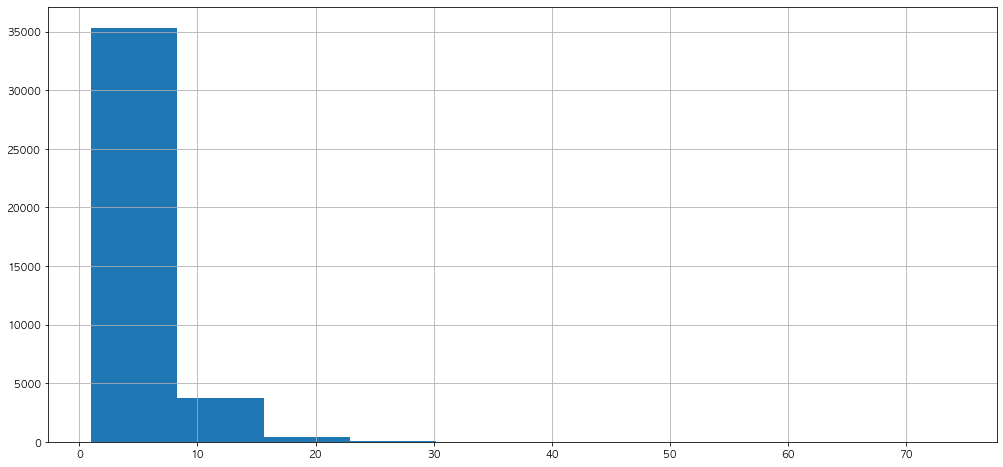

In [21]:
skw_train['ECLO'].hist()
plt.show()

In [22]:
# 로그 변환 진행 후, 다시 왜도 확인
import numpy as np

# Logarithmic transformation
skw_train['ECLO_log'] = np.log2(skw_train['ECLO'])

transform_eclo = np.log2(skw_train['ECLO'])
transform_eclo

# Check skewness of the transformed column
eclo_log_skewness = skw_train['ECLO_log'].skew()

print(f"Skewness of transformed ECLO column: {eclo_log_skewness}")

Skewness of transformed ECLO column: -0.05947172323251755


# ----------------------------------------------------------------
## **y_train을 `skw_train["ECLO_log"]` 로 사용하시면 될 것 같아요!**
# ----------------------------------------------------------------

# **📌 Random Forest**
- `target_column` : "ECLO_log"
- `eclo_y_train` : skw_train[target_column]

<br>

**'도시', '일' 제외한 df**
- `cd_features`: train_citydays
- `cd_X_train`, `cd_X_val`, `cd_y_train`, `cd_y_val`: `train_citydays` train/val 세트

## **🔻 train 데이터를 train/val 세트로 분리**

In [23]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 훈련 데이터에서 목표 변수 추출
target_column = "ECLO_log"
eclo_y_train = skw_train[target_column]



# 훈련 데이터에서 불필요한 열 제거
cd_features = train_citydays

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(cd_features, eclo_y_train, test_size=0.3)

In [24]:
# 데이터 사이즈 확인
print("Size of X_train is:{}\nSize of y_train is:{}\nSize of X_valid is:{}\nSize of y_valid is:{}\n".format(
    X_train.shape,y_train.shape,X_val.shape,y_val.shape))

Size of X_train is:(27726, 281)
Size of y_train is:(27726,)
Size of X_valid is:(11883, 281)
Size of y_valid is:(11883,)



## **1️⃣ RandomForestRegressor - 기본**
- RMSLE on Validation Set: 0.339

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# RandomForestRegressor Dataset format
# estimator 생성
rf_reg = RandomForestRegressor()

In [26]:
rf_reg.fit(X_train, y_train)
rf_pred = rf_reg.predict(X_val)

In [27]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

#  1. RMSLE 작성
def rmsle(pred, actual):
    log_pred = np.log1p(pred)
    log_actual = np.log1p(actual)
    squared_error = (log_pred-log_actual)**2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle
#  2. RMSE 작성
def rmse(pred, actual):
    return np.sqrt(mean_squared_error(pred, actual))
#  3. MAE 작성
def mae(pred, actual):
    return mean_absolute_error(pred, actual)

def evaluate_regr(pred, actual):
    rmsle_val=rmsle(pred, actual)
    rmsl_val=rmse(pred, actual)
    mae_val=mae(pred, actual)
    print('RMSLE: {:.3f}, RMSE: {:.3f}, MAE: {:.3f}'.format(rmsle_val, rmsl_val, mae_val))
 

In [28]:
evaluate_regr(rf_pred, y_val)

RMSLE: 0.350, RMSE: 0.862, MAE: 0.665


## **2️⃣ RandomForest 모델링 - 최적의 하이퍼파라미터 적용 (Randomized Search)**
- RMSLE on Validation Set: 

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

In [30]:
# 최적의 params 찾을 범위 설정
param_dist = {
    "n_estimators": sp_randint(10, 100),  # 트리 개수 범위
    "max_depth": [None] + list(sp_randint(5, 30).rvs(10)),  # 최대 깊이 범위
    "min_samples_split": sp_randint(2, 20),  # 내부 노드를 분할하기 위한 최소 샘플 수 범위
    "min_samples_leaf": sp_randint(1, 20),  # 리프 노드 최소 샘플 수 범위
    "max_features": ["auto", "sqrt", "log2"],  # 최대 feature 고려 방법
    "bootstrap": [True, False]  # 부트스트랩 사용 여부
}

# estimator 생성
rf_reg = RandomForestRegressor()

In [ ]:
# RandomizedSearchCV 객체 생성
random_search = RandomizedSearchCV(
    rf_reg, param_distributions=param_dist, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1
)

# 데이터에 대해 RandomizedSearchCV 수행
random_search.fit(X_train, y_train)

In [ ]:
# 최적의 모델 출력
best_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

In [ ]:
# 최적의 모델로 예측
y_pred = best_model.predict(X_val)

In [ ]:
# 평가
mse = mean_squared_error(y_val, y_pred)
print("Validation Mean Squared Error:", mse)

from sklearn.metrics import mean_squared_log_error
rmsle = np.sqrt(mean_squared_log_error(y_val, rf_pred))
print("RMSLE:", rmsle)

In [ ]:
evaluate_regr(y_val,rf_pred)

In [ ]:
# rf_pred_inverse = np.exp(rf_pred)
# y_val_inverse = np.exp(y_val)

rf_pred_inverse = np.exp2(rf_pred)
y_val_inverse = np.exp2(y_val)

In [ ]:
evaluate_regr(y_val_inverse, rf_pred_inverse)

## **🔻데이터를 train/test 세트로 분리**

In [32]:
X_test = test_citydays.copy()
X_train = train_citydays.copy()

In [33]:
y_train = skw_train["ECLO_log"].copy()

In [34]:
sample_submission = pd.read_csv('open/sample_submission.csv', index_col=0)
sample_submission

,ECLO
ID,
ACCIDENT_39609,0
ACCIDENT_39610,0
ACCIDENT_39611,0
ACCIDENT_39612,0
ACCIDENT_39613,0
...,...
ACCIDENT_50567,0
ACCIDENT_50568,0
ACCIDENT_50569,0


In [35]:
#y_test로 일단 데이터수 확인 위해 설정
y_test = sample_submission['ECLO'].copy()

In [36]:
# 데이터 사이즈 확인
print("Size of X_train is:{}\nSize of y_train is:{}\nSize of X_test is:{}\nSize of y_test is:{}\n".format(
    X_train.shape,y_train.shape,X_test.shape,y_test.shape))

Size of X_train is:(39609, 281)
Size of y_train is:(39609,)
Size of X_test is:(10963, 281)
Size of y_test is:(10963,)



In [37]:
# 최적의 하이퍼파라미터로 모델 생성
best_rf_model = RandomForestRegressor(bootstrap=True,
                                      max_depth=28,
                                      max_features='sqrt',
                                      min_samples_leaf=19,
                                      min_samples_split=8,
                                      n_estimators=76)

# 최적의 모델로 학습
best_rf_model.fit(X_train, y_train)

# 테스트 데이터 예측
y_pred_rfr_log = best_rf_model.predict(X_test)

In [38]:
# y_pred_rfr_log에 대한 역 로그 변환
y_pred_inverse = np.exp2(y_pred_rfr_log)

In [39]:
rf_best_submission = sample_submission.copy()
rf_best_submission['ECLO'] = y_pred_inverse
rf_best_submission

,ECLO
ID,
ACCIDENT_39609,3.753707
ACCIDENT_39610,3.417299
ACCIDENT_39611,4.411524
ACCIDENT_39612,4.188150
ACCIDENT_39613,4.413679
...,...
ACCIDENT_50567,4.359498
ACCIDENT_50568,4.228132
ACCIDENT_50569,4.070335


In [ ]:
rf_best_submission.to_csv('rf_best_submission.csv')